# MNIST Dataset Example <a name="MNIST-Dataset-Example-mnist"></a>
## Set Up Environment <a name="Set-Up-Environment-mnist"></a>
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency

## Downloading the Dataset <a name="Download-the-Dataset-mnist"></a>

The MNIST dataset consists of 70,000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

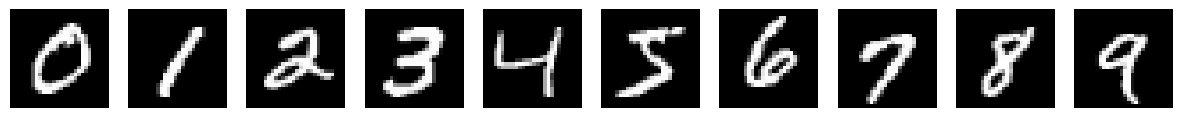

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
import os

cwd = os.getcwd()
data_dir = cwd + '/data/scikit-learn-example'

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, data_home=data_dir)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

## The "Application" <a name="The-Application-mnist"></a>

Our "application" will accept a set of images, a black-box image classifier, and a saliency generator and will generate saliency maps for each image provided.
The saliency maps from the first image in the set will then be plotted to give an idea of the model's behavior on a single sample.

Additionally, because all digits in the MNIST dataset are centered in the frame, we can average all the heatmaps generated for each respective class to produce a decision boundary visualization.
The application will do this and plot the resulting averaged heatmaps for each digit class.
This should compare to what is shown in the [first example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) discussed in the [introduction](#introduction).

In [2]:
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency

def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency
):  

    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        sal_maps_set.append(sal_maps)
    
    num_classes = sal_maps_set[0].shape[0]
    
    # Plot first image in set with saliency maps
    fig1 = plt.figure(figsize=(10,5))
    plt.suptitle("Heatmaps for First Image", fontsize=16)
    num_cols = np.ceil(num_classes/2).astype(int) + 1
    plt.subplot(2, num_cols, 1)
    plt.imshow(images[0].reshape(28,28), cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    for c in range(num_cols - 1):
        plt.subplot(2, num_cols, c + 2)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    for c in range(num_classes - num_cols + 1, num_classes):
        plt.subplot(2, num_cols, c + 3)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    
    # Average heatmaps for each respective class
    global_maps = np.sum(sal_maps_set, axis=0) / len(images)
    
    # Plot average maps
    fig2 = plt.figure(figsize=(10, 5))
    plt.suptitle("Average Heatmaps from All Images", fontsize=16)
    for c in range(num_classes):
        vcap = np.absolute(global_maps[i]).max()
        plt.subplot(2, num_cols-1, c + 1)
        plt.imshow(global_maps[c], cmap=plt.cm.RdBu, vmin=-vcap, vmax=vcap)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    return fig1, fig2, sal_maps_set

## Heatmap Generation <a name="Heatmap-Generation-mnist"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBalckboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [3]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)

# Logistic Regression Example <a name="Logistic-Regression-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-logistic-mnist"></a>

We take the same `LogisticRegression` object used in the scikit-learn example and fit it to a subset of the dataset.
Here, an L2 penalty and a larger training set is used to yield slightly better results than those shown in the example.
The same visualization of the coefficients is shown with these new parameters.

Test score with L2 penalty: 0.8865
Example run in 3.149 s


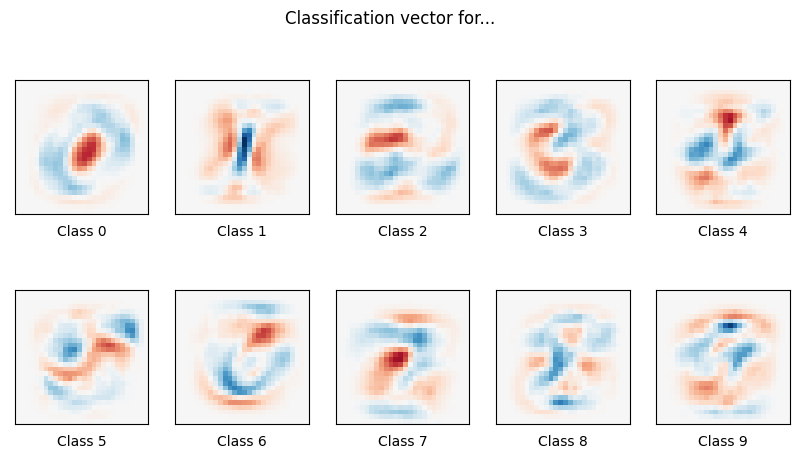

In [8]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import mlflow

# def test_mlflow():
t0 = time.time()

# Split data into test and train sets
train_samples = 20000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000, random_state=0)

# Define model, lower C value gives higher regulation
clf = LogisticRegression(
    C=50. / train_samples, penalty='l2', solver='saga', tol=0.1, random_state=0
)

# Fit model
clf.fit(X_train, y_train)

# Score model
score = clf.score(X_test, y_test)
print("Test score with L2 penalty: %.4f" % score)

# Visualize coefficients
coef = clf.coef_.copy()
max_val = np.abs(coef).max()

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    p = plt.subplot(2, 5, i + 1)
    p.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu,
            vmin=-max_val, vmax=max_val)
    p.set_xticks(())
    p.set_yticks(())
    p.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

# Sample mlflow run under Default Experiment
mlflow.set_tracking_uri("http://localhost:5000")
with mlflow.start_run():
    mlflow.log_param('model', 'Logistic Regression')
    mlflow.log_metric('score', score)
    mlflow.log_figure(fig,"class_vector.png")


# MLP Example <a name="MLP-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-mlp-mnist"></a>

Following the second [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we training an `MLPClassifier` on the MNIST dataset using the same hyperparameters.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not converge.

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from pprint import pprint
import matplotlib.pyplot as plt
from pathlib import Path

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

params = {"hidden_layer_sizes" : (50,), "max_iter" : 10, "alpha": 1e-4,
          "solver" :'sgd', "verbose": 10, "random_state": 1,
          "learning_rate_init" : .1}

mlp = MLPClassifier(**params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    x = mlp.fit(X_train, y_train)



Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


## Black-Box Classifier <a name="Black-Box-Classifier-mlp-mnist"/></a>

We wrap our `MLPClassifier` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [5]:
class MNISTClassifierMLP (ClassifyImage):
    def get_labels(self):
        return list(range(10))
    
    def classify_images(self, image_iter):
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(image_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28*28)  # may fail because input was not the correct shape
        return (
            {idx: p_i for idx, p_i in zip(range(10), p)}
            for p in mlp.predict_proba(images)
        )
    
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier_mlp = MNISTClassifierMLP()

## Calling the Application <a name="Calling-the-Application-mlp-mnist"></a>

We call our application again using the same image set and saliency generator, but this time using our MLP classifier.

The results show mostly negative saliency, suggesting that the MLP model has learned where the pixels are *absent* for each class more than where they are *present*.

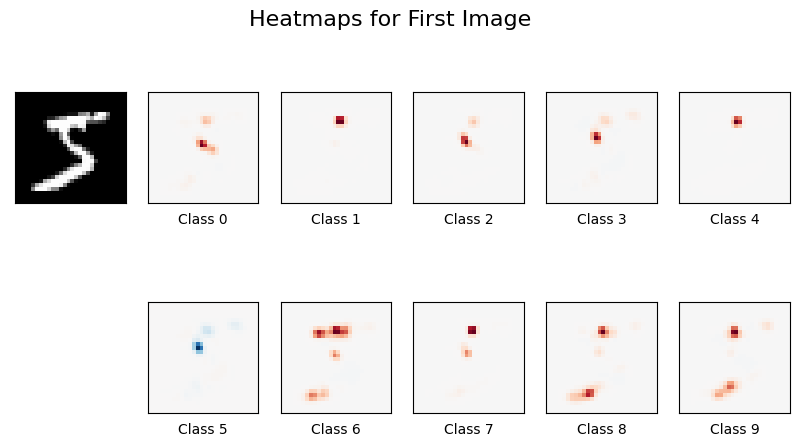

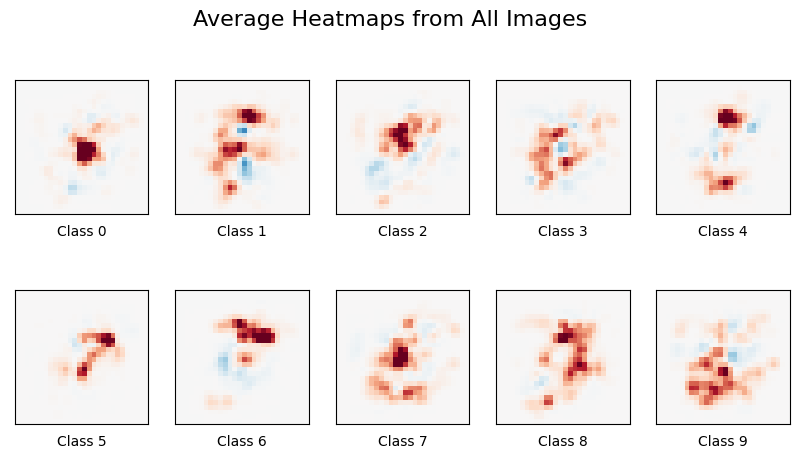

In [6]:
fig1, fig2, sal_maps = app(
    X[0:20],
    image_classifier_mlp,
    gen_slidingWindow
)

In [77]:
import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType
import random
from urllib.parse import urlparse
import uuid
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency
import matplotlib.pyplot as plt

class MLFlowXAI():

    def __init__(self,unique_pipeline_id):
        self.mlruns_path = "./mlruns"
        self.framework = "sklearn"
        self.version = "v1"
        self.pipeline_uid = unique_pipeline_id
        self.dataset = "MNIST"
        self.datasplit = "train"
        self.client = None
        self.train_exp_id = None
        self.train_run_id = None
        self.eval_exp_id = None
    
    def init_experiment(self,experiment_name):

        self.client = MlflowClient()
        client = self.client

        if not os.path.exists(self.mlruns_path):
            os.makedirs(os.path.join(self.mlruns_path,".trash"))
        
        current_experiment = client.get_experiment_by_name(experiment_name)
        
        if current_experiment == None:
            current_experiment_id = client.create_experiment(experiment_name,
                                            tags={"framework": self.framework, "version": self.version, "Pipeline_UID": self.pipeline_uid})
            client.set_experiment_tag(current_experiment_id, "Experiment", experiment_name)
            experiment_id = current_experiment_id
        else:
            experiment_id = current_experiment.experiment_id
        
        experiment = client.get_experiment(experiment_id)
        print("Name: {}".format(experiment.name))
        print("Experiment_id: {}".format(experiment.experiment_id))
        print("Artifact Location: {}".format(experiment.artifact_location))
        print("Tags: {}".format(experiment.tags))
        print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

        return experiment

    def log_training(self, experiment_name):
        
        experiment = self.init_experiment(experiment_name=experiment_name)
        
        with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="train_metrics") as run:

            # Assign train experiment and run IDs to class variables
            self.train_exp_id = experiment.experiment_id
            self.train_run_id = run.info.run_id

            # Model parameters
            mlflow.log_params(params)
            
            # Training loss
            for epoch in x.loss_curve_:
                mlflow.log_metric('Train loss',epoch)

            # Set experiment tags
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset})
            
            # Final model checkpoint
            mlflow.sklearn.log_model(x, artifact_path="sklearn-model")
            
            # Numpy array saved under artifacts
            p = urlparse(experiment.artifact_location)
            pth = os.path.abspath(os.path.join(p.netloc, p.path))
            
            np.save(os.path.join(pth,'XTrain.npy'),X_train)
    
    def log_conf_score(self, experiment_name):
        
        experiment = self.init_experiment(experiment_name=experiment_name)

        p = urlparse(experiment.artifact_location)
        pth = os.path.abspath(os.path.join(p.netloc, p.path))

        self.eval_exp_id = experiment.experiment_id
        
        img_count = 0
    
        for i in sal_maps:
            with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="ImageID-" + str(img_count) + "_conf") as run:
                
                mlflow.set_tags(experiment.tags)
                
                class_conf = []
                for j in range(0,10):
                    rand_conf = round(random.random(),2)
                    class_conf.append(rand_conf)
                
                max_conf_class = class_conf.index(max(class_conf))
                
                mlflow.log_metric('top_confidence_score', max(class_conf))
            
                mlflow.set_tags({"Image_id": str(img_count), "Top_conf_class": max_conf_class, "Class_conf": class_conf, "Dataset": self.dataset, "Datasplit": self.datasplit, "Train_exp_id": self.get_train_exp_id(), "Train_run_id": self.get_train_run_id()})
            
            img_count += 1

    def log_saliency_maps(self, experiment_name, image_id, eval_run_id):

        experiment = self.init_experiment(experiment_name=experiment_name)

        with mlflow.start_run(experiment_id=experiment.experiment_id,run_name=f"ImageID-{image_id}_saliency_maps") as run:
        
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset, "Datasplit": self.datasplit, "Evaluation_exp_id": self.get_eval_exp_id(), "Evaluation_run_id": eval_run_id})
            
            p = urlparse(experiment.artifact_location)
            pth = os.path.abspath(os.path.join(p.netloc, p.path))
            
            img_count = 0
            
            smap_path = os.path.join(pth,'saliency_map_np_arrays')
            if not os.path.exists(smap_path):
                os.makedirs(smap_path)
            
            fig1, fig2, sal_maps = self.gen_saliency_maps(image_id,X[0:20],image_classifier_mlp,gen_slidingWindow)
            
            np.save(os.path.join(smap_path,'image-' + str(image_id) + '.npy'), sal_maps[image_id])
            mlflow.log_artifact(smap_path)

            # Saliency maps saved under artifacts
            mlflow.log_figure(fig1,f'ImageID-{str(image_id)}_saliency_maps.png')
            mlflow.log_figure(fig2,'Avg_saliency_maps.png')
    
    def query_run(self,filter_string,order_by):
        
        run = mlflow.search_runs(
            experiment_ids=self.get_eval_exp_id(),
            filter_string=filter_string,
            run_view_type=ViewType.ACTIVE_ONLY,
            order_by=order_by
        )

        return run

    # xaitk "app" method modified to generate saliency maps for nth image in a given set.
    
    def gen_saliency_maps(self,
        image_id: int,
        images: np.ndarray,
        image_classifier: ClassifyImage,
        saliency_generator: GenerateImageClassifierBlackboxSaliency
    ):  

    # Generate saliency maps
        sal_maps_set = []
        for img in images:
            ref_image = img.reshape(28, 28)
            sal_maps = saliency_generator(ref_image, image_classifier)
            sal_maps_set.append(sal_maps)
        
        num_classes = sal_maps_set[0].shape[0]
        
        # Plot nth image in set with saliency maps
        fig1 = plt.figure(figsize=(10,5))
        plt.suptitle(f"Saliency Maps for Image_ID: {str(image_id)}", fontsize=16)
        num_cols = np.ceil(num_classes/2).astype(int) + 1
        plt.subplot(2, num_cols, 1)
        plt.imshow(images[image_id].reshape(28,28), cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
        for c in range(num_cols - 1):
            plt.subplot(2, num_cols, c + 2)
            plt.imshow(sal_maps_set[image_id][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        for c in range(num_classes - num_cols + 1, num_classes):
            plt.subplot(2, num_cols, c + 3)
            plt.imshow(sal_maps_set[image_id][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        plt.close(fig1)        
        # Average heatmaps for each respective class
        global_maps = np.sum(sal_maps_set, axis=0) / len(images)
        
        # Plot average maps
        fig2 = plt.figure(figsize=(10, 5))
        plt.suptitle("Average Saliency Maps from All Images", fontsize=16)
        for c in range(num_classes):
            vcap = np.absolute(global_maps[i]).max()
            plt.subplot(2, num_cols-1, c + 1)
            plt.imshow(global_maps[c], cmap=plt.cm.RdBu, vmin=-vcap, vmax=vcap)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        plt.close(fig2)
        
        return fig1, fig2, sal_maps_set

    def get_train_run_id(self):
        return self.train_run_id
    
    def get_train_exp_id(self):
        return self.train_exp_id

    def get_eval_exp_id(self):
        return self.eval_exp_id

In [78]:
# Generate a unique experiment id that is accessible across the end-to-end pipeline.

unique_pipeline_id = uuid.uuid1()
print(f"Unique experiment pipeline ID: {str(unique_pipeline_id)}")

# Create an MLFlowXAI object using the unique experiment ID

MLFlowXAIobj = MLFlowXAI(unique_pipeline_id)

Unique experiment pipeline ID: 29453dac-8d3a-11ed-8b36-891896653031


In [79]:
# Log training metrics for the trained sklearn MLP Classifier

MLFlowXAIobj.log_training("MLP Classifier- Train")

Name: MLP Classifier- Train
Experiment_id: 766108724242998153
Artifact Location: file:///data/barry.ravichandran/XAITK/xaitk-cdao/examples/mlflow/mlruns/766108724242998153
Tags: {'version': 'v1', 'Pipeline_UID': '29453dac-8d3a-11ed-8b36-891896653031', 'framework': 'sklearn', 'Experiment': 'MLP Classifier- Train'}
Lifecycle_stage: active


In [80]:
# Log per image confidence scores (currently using random values for conf scores)

MLFlowXAIobj.log_conf_score("MLP Classifier- Evaluation")

Name: MLP Classifier- Evaluation
Experiment_id: 706853578827398420
Artifact Location: file:///data/barry.ravichandran/XAITK/xaitk-cdao/examples/mlflow/mlruns/706853578827398420
Tags: {'version': 'v1', 'Pipeline_UID': '29453dac-8d3a-11ed-8b36-891896653031', 'framework': 'sklearn', 'Experiment': 'MLP Classifier- Evaluation'}
Lifecycle_stage: active


In [81]:
# Filter and query based on tag(s) and metric(s) of choice

filter_string = f"metrics.top_confidence_score >= 0.6 and tags.Top_conf_class = '3'"
order_by = ["metrics.top_confidence_score DESC"]

queried_runs = MLFlowXAIobj.query_run(filter_string=filter_string,order_by=order_by)

In [82]:
# Generate and log saliency maps for the queried image id and store the corresponding run id from the scoring stage.

top_confScore_imgID = int(queried_runs["tags.Image_id"][0])
top_confScore_runID = str(queried_runs["run_id"][0])

MLFlowXAIobj.log_saliency_maps("MLP Classifier - Saliency Map Generation", top_confScore_imgID, top_confScore_runID)

Name: MLP Classifier - Saliency Map Generation
Experiment_id: 371939693661139171
Artifact Location: file:///data/barry.ravichandran/XAITK/xaitk-cdao/examples/mlflow/mlruns/371939693661139171
Tags: {'version': 'v1', 'Pipeline_UID': '29453dac-8d3a-11ed-8b36-891896653031', 'framework': 'sklearn', 'Experiment': 'MLP Classifier - Saliency Map Generation'}
Lifecycle_stage: active
